## Importing Libraries

In [1]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [2]:
!pip install transformers torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.8 MB/s eta 0:00:00


In [4]:
import re
import json
import torch
import zipfile
import sklearn
import logging
import numpy as np
import transformers
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 150



from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import RobertaModel, RobertaTokenizer

logging.basicConfig(level=logging.ERROR)
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import BertTokenizer, TFBertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaTokenizer, RobertaForSequenceClassification,get_linear_schedule_with_warmup

## Reading Dataset

In [6]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/sentiment_analysis.zip", 'r')
zip_ref.extractall("/content/files/")
zip_ref.close()

In [9]:
df=pd.read_csv("/content/drive/My Drive/data/train.csv",encoding="iso-8859-1")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [10]:
len(df)

27481

## Pre-processing Data

In [11]:
def preprocessing(text):
  regex = r'[^\w\s]|[\U0001f600-\U0001f64f\U0001f300-\U0001f5ff\U0001f680-\U0001f6ff\U0001f1e0-\U0001f1ff]'
  text=re.sub(regex," ",text)
  text=re.sub("\.|\,|\/|\-"," ",text) 
  text=re.sub("\s*\s"," ",text)
  return text

In [12]:
for i in range(len(df)):
  df.loc[i,"text"]=preprocessing(str(df.loc[i,"text"]))

In [13]:
df["sentiment"]=df["sentiment"].replace({"neutral":0,"positive":1,"negative":2})

In [14]:
df=df[["text","sentiment"]]

## Training Model

In [15]:
train_text,test_text,train_labels,test_labels=train_test_split(df["text"],df["sentiment"],test_size=0.4)
val_text,test_text,val_labels,test_labels=train_test_split(test_text,test_labels,test_size=0.4)

In [17]:
num_classes = 3

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [18]:
def convert_example_to_feature(review):
  return bert_tokenizer.encode_plus(review, 
                add_special_tokens = True,     # add [CLS], [SEP]
                max_length = 512,              # max length of the text that can go to BERT
                padding='max_length',
                truncation=True,
                return_attention_mask = True,  # add attention mask to not focus on pad tokens
              )

In [19]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for review, label in ds:
    bert_input = convert_example_to_feature(review)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)


In [20]:
batch_size = 8

In [21]:
ds_train = zip(train_text, train_labels)
ds_test = zip(test_text, test_labels)
ds_train_encoded = encode_examples(ds_train).shuffle(len(train_text)).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

In [22]:
# log_dir = './sentiment-analysis-using-bert-keras/tensorboard_data/tb_bert'
model_save_path = 'bert_model.h5'

path = "/content/"

## Initialize pre-built BERT-based classifier from transformers
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=num_classes)

bert_model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


In [23]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 4

# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=metric)

In [24]:
history = bert_model.fit(ds_train_encoded,
                         batch_size=batch_size,
                         epochs=number_of_epochs,
                         validation_data=ds_test_encoded)

Epoch 1/4
2061/2061 [==============================] - 2153s 1s/step - loss: 0.6095 - accuracy: 0.7461 - val_loss: 0.5331 - val_accuracy: 0.7897
Epoch 2/4
2061/2061 [==============================] - 2116s 1s/step - loss: 0.4242 - accuracy: 0.8379 - val_loss: 0.5680 - val_accuracy: 0.7847
Epoch 3/4
2061/2061 [==============================] - 2119s 1s/step - loss: 0.2600 - accuracy: 0.9047 - val_loss: 0.6485 - val_accuracy: 0.7713
Epoch 4/4
2061/2061 [==============================] - 2116s 1s/step - loss: 0.1557 - accuracy: 0.9460 - val_loss: 0.8224 - val_accuracy: 0.7708


In [25]:
bert_model.save_weights(model_save_path)

## Results

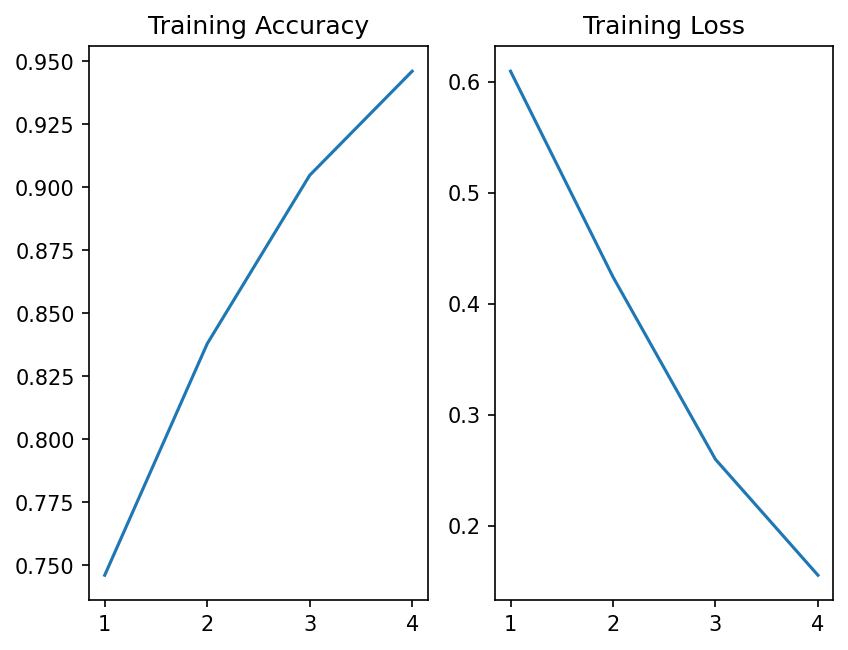

In [39]:
# Plotting results
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

fig=plt.figure()

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc)
plt.title("Training Accuracy")
fig.add_subplot(1, 2, 2)
plt.plot(epochs, loss)
plt.title("Training Loss")
plt.show()

In [27]:
bert_model.evaluate(ds_test_encoded,batch_size=batch_size)

550/550 [==============================] - 191s 347ms/step - loss: 0.8224 - accuracy: 0.7708


[0.8223556280136108, 0.7708048820495605]

In [28]:
y_test_pred = bert_model.predict(ds_test_encoded,batch_size=batch_size)

550/550 [==============================] - 192s 341ms/step


In [29]:
y_test_pred_class = y_test_pred[0].argmax(axis=1)

In [30]:
import itertools
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6), dpi=150)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j,i,"{:0.4f}".format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j,i,"{:,}".format(cm[i, j]),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    plt.show()

In [31]:
cm = sklearn.metrics.confusion_matrix(test_labels,
                                      y_test_pred_class,
                                      normalize=None)

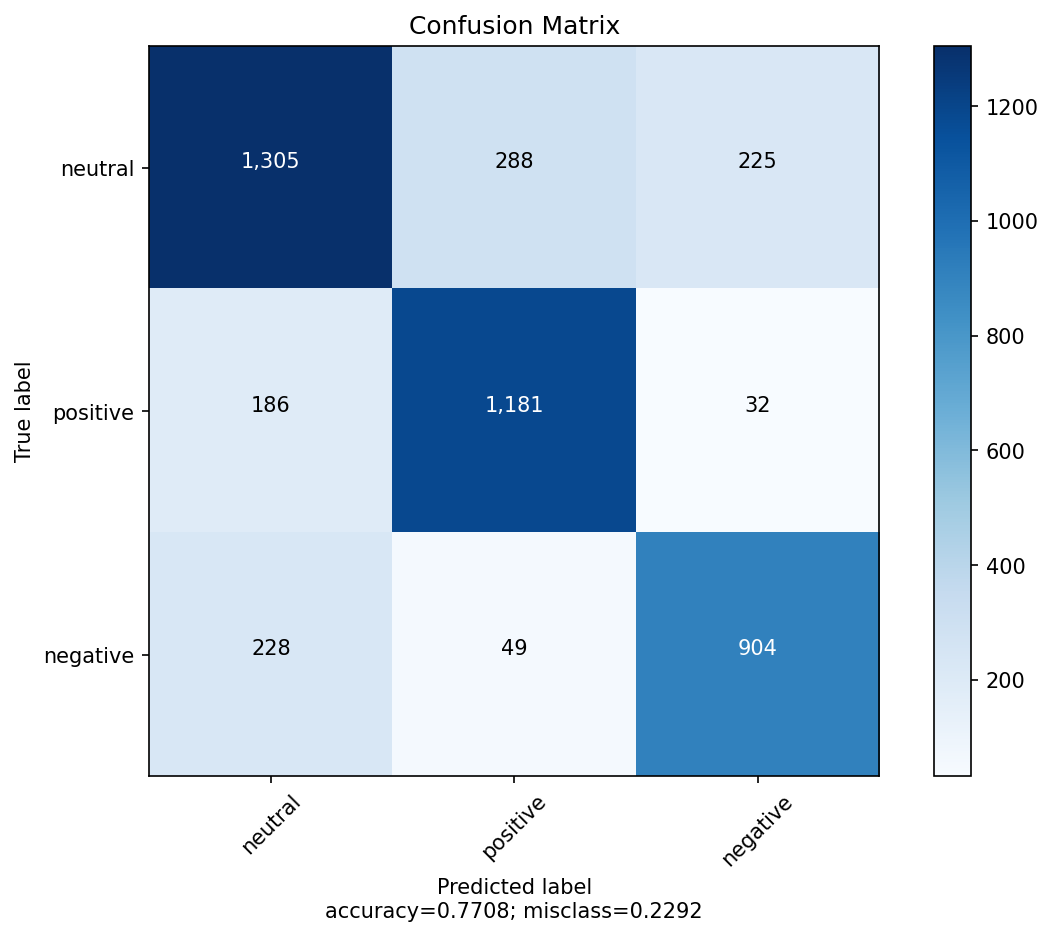

In [32]:
plot_confusion_matrix(cm,
                      normalize=False,
                      target_names=['neutral', 'positive',"negative"],
                      title="Confusion Matrix")